In [1]:
import torch
import torch_geometric as tg
from torch_geometric.data import Data
import networkx as nx
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_add_pool
from torch_geometric.loader import DataLoader

In [4]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

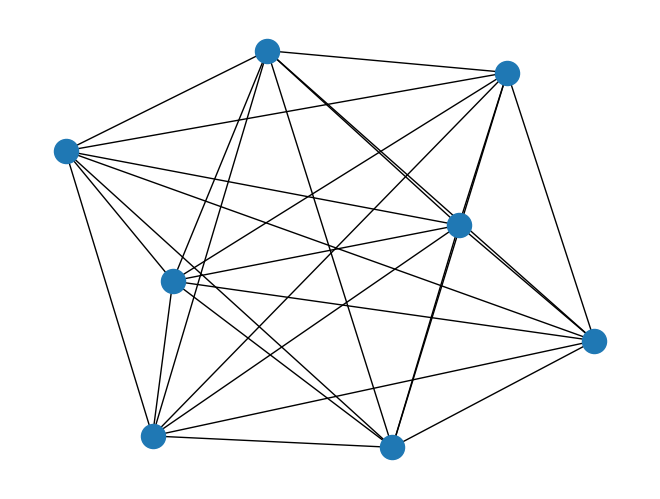

In [60]:
g = tg.utils.to_networkx(data1, to_undirected=True)
nx.draw(g)

In [3]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

Now I want to add graphs with our need for Ng sets for testing

In [16]:
complete_graph_list = []
for i in range(8):
    for j in range(8):
        if i != j:
            complete_graph_list.append([i,j])
edge_index = torch.tensor(complete_graph_list, dtype=torch.long)

In [39]:
from math import sqrt

In [68]:
edges_to_check = [[2,6], [3,6], [5,6], [4,6]]
dependent_arcs = []
for i in range(8):
    for j in range(8):
        if i != j:
            if [i,j] in edges_to_check:
                dependent_arcs.append(1)
            else:
                dependent_arcs.append(0)
y = torch.tensor(dependent_arcs, dtype=torch.long)
x = torch.tensor([[0, 3, 2], [1, 1, 6], [2, 3, 6], [3, 5, 6], [4, 6, 5], [5, 4, 4], [6, 3, 4], [7, 1, 3]], dtype=torch.float)
attr = [[i] for i in range(len(edge_index))]
loc_list = [[0, 3, 2], [1, 1, 6], [2, 3, 6], [3, 5, 6], [4, 6, 5], [5, 4, 4], [6, 3, 4], [7, 1, 3]]
loc_dict = {(i[0],j[0]): sqrt((i[1]-j[1])**2 + (i[2]-j[2])**2) if i != j else next for i in loc_list for j in loc_list}
cnt = -1
for i in range(8):
    for j in range(8):
        if i != j:
            cnt += 1
            attr[cnt].append(loc_dict[i,j])
attr = torch.tensor(attr, dtype=torch.long)
pos = []
for i in loc_list:
    pos.append([i[1], i[2]])
pos = torch.tensor(pos)

data1 = Data(x=x, y=y.t().contiguous(), edge_index=edge_index.t().contiguous(), pos=pos, edge_attr=attr)

In [69]:
print(data1.edge_attr)

tensor([[ 0,  4],
        [ 1,  4],
        [ 2,  4],
        [ 3,  4],
        [ 4,  2],
        [ 5,  2],
        [ 6,  2],
        [ 7,  4],
        [ 8,  2],
        [ 9,  4],
        [10,  5],
        [11,  3],
        [12,  2],
        [13,  3],
        [14,  4],
        [15,  2],
        [16,  2],
        [17,  3],
        [18,  2],
        [19,  2],
        [20,  3],
        [21,  4],
        [22,  4],
        [23,  2],
        [24,  1],
        [25,  2],
        [26,  2],
        [27,  5],
        [28,  4],
        [29,  5],
        [30,  3],
        [31,  1],
        [32,  2],
        [33,  3],
        [34,  5],
        [35,  2],
        [36,  3],
        [37,  2],
        [38,  2],
        [39,  2],
        [40,  1],
        [41,  3],
        [42,  2],
        [43,  2],
        [44,  2],
        [45,  2],
        [46,  3],
        [47,  1],
        [48,  2],
        [49,  2],
        [50,  3],
        [51,  3],
        [52,  5],
        [53,  5],
        [54,  3],
        [5

In [71]:
edges_to_check = [[3,1], [2,1]]
dependent_arcs = []
for i in range(8):
    for j in range(8):
        if i != j:
            if [i,j] in edges_to_check:
                dependent_arcs.append(1)
            else:
                dependent_arcs.append(0)
y = torch.tensor(dependent_arcs, dtype=torch.long)
x = torch.tensor([[0, 4, 4], [1, 2, 4], [2, 2, 5], [3, 2, 2], [4, 4, 1], [5, 6, 6], [6, 7, 3], [7, 3, 7]], dtype=torch.float)
attr = [[i] for i in range(len(edge_index))]
loc_list = [[0, 4, 4], [1, 2, 4], [2, 2, 5], [3, 2, 2], [4, 4, 1], [5, 6, 6], [6, 7, 3], [7, 3, 7]]
loc_dict = {(i[0],j[0]): sqrt((i[1]-j[1])**2 + (i[2]-j[2])**2) if i != j else next for i in loc_list for j in loc_list}
cnt = -1
for i in range(8):
    for j in range(8):
        if i != j:
            cnt += 1
            attr[cnt].append(loc_dict[i,j])
attr = torch.tensor(attr, dtype=torch.long)
pos = []
for i in loc_list:
    pos.append([i[1], i[2]])
pos = torch.tensor(pos)

data2 = Data(x=x, y=y.t().contiguous(), edge_index=edge_index.t().contiguous(), pos=pos, edge_attr=attr)

In [72]:
edges_to_check = [[3,7], [5,7]]
dependent_arcs = []
for i in range(8):
    for j in range(8):
        if i != j:
            if [i,j] in edges_to_check:
                dependent_arcs.append(1)
            else:
                dependent_arcs.append(0)
y = torch.tensor(dependent_arcs, dtype=torch.long)
x = torch.tensor([[0, 6, 2], [1, 1, 3], [2, 3, 7], [3, 6, 6], [4, 1, 7], [5, 6, 4], [6, 4, 3], [7, 7, 5]], dtype=torch.float)
attr = [[i] for i in range(len(edge_index))]
loc_list = [[0, 6, 2], [1, 1, 3], [2, 3, 7], [3, 6, 6], [4, 1, 7], [5, 6, 4], [6, 4, 3], [7, 7, 5]]
loc_dict = {(i[0],j[0]): sqrt((i[1]-j[1])**2 + (i[2]-j[2])**2) if i != j else next for i in loc_list for j in loc_list}
cnt = -1
for i in range(8):
    for j in range(8):
        if i != j:
            cnt += 1
            attr[cnt].append(loc_dict[i,j])
attr = torch.tensor(attr, dtype=torch.long)
pos = []
for i in loc_list:
    pos.append([i[1], i[2]])
pos = torch.tensor(pos)

data3 = Data(x=x, y=y.t().contiguous(), edge_index=edge_index.t().contiguous(), pos=pos, edge_attr=attr)

In [73]:
edges_to_check = [[1,7], [5,7], [2,3], [6,3]]
dependent_arcs = []
for i in range(8):
    for j in range(8):
        if i != j:
            if [i,j] in edges_to_check:
                dependent_arcs.append(1)
            else:
                dependent_arcs.append(0)
y = torch.tensor(dependent_arcs, dtype=torch.long)
x = torch.tensor([[0, 4, 3], [1, 1, 1], [2, 6, 6], [3, 7,5], [4, 2, 5], [5, 3, 1], [6, 7,3], [7, 2,2]], dtype=torch.float)
attr = [[i] for i in range(len(edge_index))]
loc_list = [[0, 4, 3], [1, 1, 1], [2, 6, 6], [3, 7,5], [4, 2, 5], [5, 3, 1], [6, 7,3], [7, 2,2]]
loc_dict = {(i[0],j[0]): sqrt((i[1]-j[1])**2 + (i[2]-j[2])**2) if i != j else next for i in loc_list for j in loc_list}
cnt = -1
for i in range(8):
    for j in range(8):
        if i != j:
            cnt += 1
            attr[cnt].append(loc_dict[i,j])
attr = torch.tensor(attr, dtype=torch.long)
pos = []
for i in loc_list:
    pos.append([i[1], i[2]])
pos = torch.tensor(pos)

data4 = Data(x=x, y=y.t().contiguous(), edge_index=edge_index.t().contiguous(), pos=pos, edge_attr=attr)

In [80]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv1 = GCNConv(3, 2)
        # self.conv2 = SAGEConv(2,8)
        num_features = 3
        dim = 56
        features = 56

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 56)

    def forward(self, x, edge_index, batch, edge_weight=None):
        # x, edge_index = data.x, data.edge_index

        # x = self.conv1(x, edge_index)
        # x = F.relu(x)
        # x = F.sigmoid(self.conv2(x, edge_index))
        # x = F.dropout(x, training=self.training)
        # x = self.conv2(x, edge_index)

        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

        # return x
        # return x
        

In [81]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        # print(output, data.y)
        # print(output)
        loss = F.l1_loss(output[0], data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / 4

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / 4

In [74]:
data_list = [data1, data2, data3, data4]
dataloader = DataLoader(data_list, batch_size=1)
data_iter = iter(dataloader)

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(dataloader)
    test_acc = test(dataloader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 109.2643, Train Acc: 2.0000, Test Acc: 2.0000
Epoch: 002, Loss: 85.5794, Train Acc: 3.0000, Test Acc: 3.0000
Epoch: 003, Loss: 51.6510, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 004, Loss: 36.3253, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 005, Loss: 39.6960, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 006, Loss: 28.4578, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 007, Loss: 15.0359, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 008, Loss: 15.1526, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 009, Loss: 7.6742, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 010, Loss: 5.1370, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 011, Loss: 4.5597, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 012, Loss: 4.8443, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 013, Loss: 4.0847, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 014, Loss: 4.0836, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 015, Loss: 4.0906, Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 016, Loss: 4.0819, Train Acc: 0.0000, Test Acc: 0.0000

In [83]:
print(model(data1.x, data1.edge_index, data1.batch))

tensor([[-4.1071, -4.1501, -4.0723, -4.0766, -4.0141, -4.0125, -4.0495, -4.0744,
         -3.9675, -3.9538, -4.0993, -3.9662, -4.0108, -4.0182, -3.9789, -4.0058,
         -4.0230, -4.0914, -3.9619, -4.0678, -4.0535, -3.9740, -3.9900, -4.0338,
         -3.9822, -3.9320, -3.9537, -4.0625, -4.0228, -4.0420, -3.9686, -4.0979,
         -4.0211, -3.9790, -4.1766, -4.0589, -4.0102, -3.9617, -4.0303, -4.0415,
         -3.9674, -3.9588, -4.0272, -4.0858, -4.0073, -4.0519, -4.0711, -4.0162,
         -4.0823, -3.9716, -3.9764, -3.9318, -4.0532, -4.0651, -4.0218, -4.1204]],
       grad_fn=<LogSoftmaxBackward0>)


In [30]:
print(model(data1.x, data1.edge_index, data1.batch).max(dim=1))

torch.return_types.max(
values=tensor([-3.8952], grad_fn=<MaxBackward0>),
indices=tensor([43]))


In [78]:
from math import exp

sol1 = model(data1.x, data1.edge_index, data1.batch).tolist()[0]

pos = -1
for i in range(8):
    for j in range(8):
        if i != j:
            pos +=1
            print(exp(sol1[pos]), i, j)

0.017054583756193526 0 1
0.018807433040471482 0 2
0.01864622709283721 0 3
0.0185163893971816 0 4
0.018901960220738468 0 5
0.01913803475351945 0 6
0.0169980851558266 0 7
0.019324264818562746 1 0
0.0172632634093058 1 2
0.01623241383072122 1 3
0.019217034505268488 1 4
0.018716506438001275 1 5
0.019432408517537848 1 6
0.017196665509857295 1 7
0.018392704079795236 2 0
0.01813460166125799 2 1
0.019511106863446582 2 3
0.015423137776570301 2 4
0.018696017565700843 2 5
0.01652251705407729 2 6
0.01994147649637608 2 7
0.019009712026023782 3 0
0.01645280542877164 3 1
0.017392912456847313 3 2
0.016292868869727594 3 4
0.01966279356453263 3 5
0.01931744727108654 3 6
0.017623689701140186 3 7
0.016355358295294855 4 0
0.01608023142455609 4 1
0.017299966654668774 4 2
0.01933289154131632 4 3
0.016939075731398065 4 5
0.01789201449024852 4 6
0.01835694281012177 4 7
0.018236770311277073 5 0
0.016057865118093186 5 1
0.018025354080497637 5 2
0.017245080789824133 5 3
0.015916940086974186 5 4
0.01907635774931936

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
batches = {}
for batch_idx in range(len(data_list)):
    batches[batch_idx] = data_list[batch_idx].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    in_between_loss = 0
    within_loss = 0
    for batch_idx in range(len(data_list)):
        batch = batches[batch_idx]
        out = model(batch)
        loss = F.mse_loss(out, batches[batch_idx].y)
        within_loss += loss.data.item()
    in_between_loss = [within_loss/len(data_list)]
    loss.data = torch.tensor(in_between_loss, dtype=torch.float)
    loss.backward()
    optimizer.step()

In [57]:
model.eval()
pred = model(data1)
print(pred)
correct = ([pred[i][j] == data.y[i][j] for i in range(8) for j in range(8)]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

tensor([[0.0027, 0.0695, 0.0690, 0.0038, 0.0034, 0.0640, 0.0821, 0.0026],
        [0.0027, 0.0695, 0.0690, 0.0038, 0.0034, 0.0640, 0.0821, 0.0026],
        [0.0027, 0.0695, 0.0690, 0.0038, 0.0034, 0.0640, 0.0821, 0.0026],
        [0.0027, 0.0695, 0.0690, 0.0038, 0.0034, 0.0640, 0.0821, 0.0026],
        [0.0027, 0.0695, 0.0690, 0.0038, 0.0034, 0.0640, 0.0821, 0.0026],
        [0.0027, 0.0695, 0.0690, 0.0038, 0.0034, 0.0640, 0.0821, 0.0026],
        [0.0027, 0.0695, 0.0690, 0.0038, 0.0034, 0.0640, 0.0821, 0.0026],
        [0.0027, 0.0695, 0.0690, 0.0038, 0.0034, 0.0640, 0.0821, 0.0026]],
       grad_fn=<SigmoidBackward0>)


TypeError: 'NoneType' object is not subscriptable

In [2]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

path = '.'
dataset = TUDataset(path, name='Mutagenicity').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [3]:
from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_index=[2, 24], x=[13, 14], edge_attr=[24, 3], y=[1])
Number of nodes: 13
Number of edges: 24
Average node degree: 1.85
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)
    
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        print(output)
        print(data.y)
        exit()
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 2):
    loss = train(epoch)
    train_acc = test(train_loader)
    exit()
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

tensor([[-7.9544e-02, -2.5710e+00],
        [ 0.0000e+00, -2.4521e+01],
        [-3.2041e+00, -4.1441e-02],
        [-1.3136e-01, -2.0948e+00],
        [-3.5234e-01, -1.2142e+00],
        [-2.9585e-01, -1.3622e+00],
        [-1.0162e-02, -4.5942e+00],
        [-1.0766e+00, -4.1666e-01],
        [-4.9121e-01, -9.4645e-01],
        [-1.9291e-01, -1.7405e+00],
        [-2.3842e-07, -1.5343e+01],
        [-6.2136e-04, -7.3840e+00],
        [-4.8757e-01, -9.5223e-01],
        [-6.1950e-01, -7.7265e-01],
        [-3.7913e+00, -2.2825e-02],
        [-5.1425e-01, -9.1117e-01],
        [-3.0185e-01, -1.3450e+00],
        [ 0.0000e+00, -1.8063e+01],
        [-1.1951e-01, -2.1835e+00],
        [-9.5585e-02, -2.3951e+00],
        [-2.2438e+00, -1.1211e-01],
        [-3.7700e-01, -1.1581e+00],
        [-7.2500e-01, -6.6228e-01],
        [-2.9350e+00, -5.4594e-02],
        [-2.7798e-01, -1.4160e+00],
        [-1.1085e+01, -1.5378e-05],
        [-1.8863e-01, -1.7608e+00],
        [-7.6554e-01, -6.256

: 

play with actual data

In [9]:
import os

data_files_list = ["./export/"+f for f in os.listdir("./export") ]
instance_dict = {}
for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

ng_dict = {}
cnt = -1
with open("ng_outs.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            ng_dict[instance] = [[0 for i in range(101)]]
        ng_dict[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [173]:
print((ng_dict['J000000'][0]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
from math import sqrt
import torch
import torch_geometric as tg
from torch_geometric.data import Data
import networkx as nx
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_add_pool
from torch_geometric.loader import DataLoader

In [7]:
complete_graph_list = []
for i in range(101):
    for j in range(101):
        if i != j:
            complete_graph_list.append([i,j])
edge_index = torch.tensor(complete_graph_list, dtype=torch.long).t().contiguous()
n_edges = len(complete_graph_list)

In [10]:
for instance_name in ng_dict:
    for i in range(101):
        for j in range(101):
            if i == j:
                ng_dict[instance_name][i][j] = 0

In [11]:
data_list = []
for instance_name in ng_dict:
    y = torch.tensor(ng_dict[instance_name], dtype=torch.double)
    x = torch.tensor(instance_dict[instance_name], dtype=torch.double)
    attr = [[i] for i in range(n_edges)]
    loc_dict = {(i[0],j[0]): sqrt((i[1]-j[1])**2 + (i[2]-j[2])**2) for i in instance_dict[instance_name] for j in instance_dict[instance_name]}
    cnt = -1
    for i in range(101):
        for j in range(101):
            if i != j:
                cnt += 1
                attr[cnt].append(loc_dict[i,j])
    attr = torch.tensor(attr, dtype=torch.double)
    pos = []
    for i in instance_dict[instance_name]:
        pos.append([i[1], i[2]])
    pos = torch.tensor(pos, dtype=torch.double)
    data_list.append(Data(x=x, y=y, edge_index=edge_index, pos=pos, edge_attr=attr))

In [236]:

dataloader = DataLoader(data_list[428:458], batch_size=1)
data_iter = iter(dataloader)
data_test = DataLoader(data_list[458:468], batch_size=1)

In [12]:
# Just to produce edges as an adjacency matrix
complete_adj_matrix_list = [[0 for i in range(101)] for i in range(101)]
for edge in complete_graph_list:
    i, j = edge
    complete_adj_matrix_list[i][j] = 1

In [13]:

class Instances:
    def __init__(self, data_list):
        self.data_list = data_list
    
    def to_torch_geometric(self, start=0, end=-1, batch_size=1):
        return DataLoader(data_list[start:end], batch_size=batch_size)
    
    def to_conv_nets(self, start=0, end=-1, batch_size=1):
        final_data = []
        nodes = []
        nodes_coor = []
        nodes_timew = []
        x_edges = []
        x_edges_values = []
        y_edges = []
        cnt = 0
        current_batch = 0
        for graph in self.data_list[start:end]:
            if cnt >= batch_size:
                cnt = 0
                current_batch += 1
                nodes = torch.tensor(nodes, dtype=torch.long)
                nodes_coor = torch.tensor(nodes_coor, dtype=torch.float)
                nodes_timew = torch.tensor(nodes_timew, dtype=torch.long)
                x_edges = torch.tensor(x_edges, dtype=torch.long)
                x_edges_values = torch.tensor(x_edges_values, dtype=torch.float)
                y_edges = torch.tensor(y_edges, dtype=torch.long)
                final_data.append((x_edges, x_edges_values, nodes, nodes_coor, nodes_timew, y_edges))
                nodes = []
                nodes_coor = []
                nodes_timew = []
                x_edges = []
                x_edges_values = []
                y_edges = []
            nodes.append([i for i in range(101)]) 
            nodes_coor.append(graph.pos.tolist())
            tw = []
            x_raw = graph.x.tolist()
            for i in range(101):
                tw.append([x_raw[i][4], x_raw[i][5]])
            nodes_timew.append(tw)
            x_edges.append(complete_adj_matrix_list)
            dist_matrix = [[0 for _ in range(101)] for _ in range(101)]
            dist_list = [i for _, i in graph.edge_attr.tolist()]
            pos_dist = 0
            for i in range(101):
                for j in range(101):
                    if i != j:
                        dist_matrix[i][j] = dist_list[pos_dist]
                        pos_dist += 1
            x_edges_values.append(dist_matrix)
            y_edges.append(graph.y.tolist()) #TODO: remove the transpose and also the contiguous when generating y
            cnt += 1
        return final_data


In [14]:
data_source = Instances(data_list)
dataloader = data_source.to_torch_geometric(start=428, end=458, batch_size=1)
datatorch = data_source.to_conv_nets(start=428, end=458, batch_size=1)
torchtest = data_source.to_conv_nets(start=458, end=468, batch_size=1)

In [10]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_features = 7
        dim = 101*101

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)

        self.double()

    def forward(self, x, edge_index, batch, edge_weight=None):
        # x, edge_index = data.x, data.edge_index

        # x = self.conv1(x, edge_index)
        # x = F.relu(x)
        # x = F.sigmoid(self.conv2(x, edge_index))
        # x = F.dropout(x, training=self.training)
        # x = self.conv2(x, edge_index)

        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        # x = self.lin2(x)
        x = torch.reshape(x, (101, 101))
        return x

In [243]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        # print(data.x, data.edge_index, data.batch)
        output = model(data.x, data.edge_index, data.batch)
        # print(output, data.y)
        # print(output)
        loss = F.l1_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
        test_size = 10
    return loss_all / test_size

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        test_size = 10
    return correct / test_size

In [244]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 33):
    loss = train(epoch)
    train_acc = test(dataloader)
    test_acc = test(data_test)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 12316329.8885, Train Acc: 27914.9000, Test Acc: 9321.4000
Epoch: 002, Loss: 15050.8765, Train Acc: 27375.4000, Test Acc: 9180.6000
Epoch: 003, Loss: 6520.1387, Train Acc: 29867.4000, Test Acc: 9922.2000
Epoch: 004, Loss: 3516.2888, Train Acc: 29887.2000, Test Acc: 9941.8000
Epoch: 005, Loss: 3118.8949, Train Acc: 29746.9000, Test Acc: 9921.7000
Epoch: 006, Loss: 2790.8632, Train Acc: 29253.6000, Test Acc: 9770.8000
Epoch: 007, Loss: 6193.2795, Train Acc: 28825.8000, Test Acc: 9601.0000
Epoch: 008, Loss: 10322.0821, Train Acc: 29437.1000, Test Acc: 9821.8000
Epoch: 009, Loss: 8848.0151, Train Acc: 29436.2000, Test Acc: 9821.8000
Epoch: 010, Loss: 3819.2164, Train Acc: 29756.7000, Test Acc: 9922.1000
Epoch: 011, Loss: 2152.1094, Train Acc: 30037.2000, Test Acc: 10022.2000
Epoch: 012, Loss: 4402.4668, Train Acc: 29436.8000, Test Acc: 9821.6000
Epoch: 013, Loss: 4791.5913, Train Acc: 30337.9000, Test Acc: 10122.4000
Epoch: 014, Loss: 5397.9118, Train Acc: 30037.9000, Test

In [239]:
print(model)

Net(
  (conv1): GraphConv(7, 10201)
  (conv2): GraphConv(10201, 10201)
  (conv3): GraphConv(10201, 10201)
  (conv4): GraphConv(10201, 10201)
  (conv5): GraphConv(10201, 10201)
  (lin1): Linear(in_features=10201, out_features=10201, bias=True)
  (lin2): Linear(in_features=10201, out_features=10201, bias=True)
)


In [238]:
model.eval()
data_show = data_list[430]
pred = model(data_show.x, data_show.edge_index, data_show.batch).tolist()
y = data_show.y
diff = 0
for j in range(len(pred)):
    a_list = [1 if i*100 > 1 else 0 for i in pred[j]]
    diff += sum([(y[j][i].tolist() - a_list[i])**2 for i in range(len(a_list))])
    print([1 if i*10 > 0.1 else 0 for i in pred[j]], sum(a_list))
print(diff)
print(sum([y[j][i].tolist() for i in range(101) for j in range(101)]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [31]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_scatter import scatter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [32]:
class BatchNormNode(nn.Module):
    """Batch normalization for node features.
    """

    def __init__(self, hidden_dim):
        super(BatchNormNode, self).__init__()
        self.batch_norm = nn.BatchNorm1d(hidden_dim, track_running_stats=False)

    def forward(self, x):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)

        Returns:
            x_bn: Node features after batch normalization (batch_size, num_nodes, hidden_dim)
        """
        # The batch norm normalizes the hidden dim over batch and node dimensions
        if x.dim() == 2:
            # If we have sparse version we have only one batch dimension
            # simply perform batch norm over this (so this normalizes over batch and node dimension)
            return self.batch_norm(x)
        x_trans = x.transpose(1, 2).contiguous()  # Reshape input: (batch_size, hidden_dim, num_nodes)
        x_trans_bn = self.batch_norm(x_trans)
        x_bn = x_trans_bn.transpose(1, 2).contiguous()  # Reshape to original shape
        # x_bn2 = self.batch_norm(x.view(-1, x.size(-1))).view_as(x)
        # assert torch.allclose(x_bn, x_bn2, atol=1e-5)
        return x_bn


class BatchNormEdge(nn.Module):
    """Batch normalization for edge features.
    """

    def __init__(self, hidden_dim):
        super(BatchNormEdge, self).__init__()
        self.batch_norm = nn.BatchNorm2d(hidden_dim, track_running_stats=False)

    def forward(self, e):
        """
        Args:
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            e_bn: Edge features after batch normalization (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        # The batch norm normalizes the hidden dim over batch and edge dimensions
        if e.dim() == 2:
            # If we have sparse version we have only one batch dimension
            # simply perform batch norm over this (so this normalizes over batch and node dimension)
            # We can use the BatchNorm2d module by inserting dummy dimensions
            return self.batch_norm(e[:, :, None, None]).view_as(e)
        e_trans = e.transpose(1, 3).contiguous()  # Reshape input: (batch_size, hidden_dim, num_nodes, num_nodes)
        e_trans_bn = self.batch_norm(e_trans)
        e_bn = e_trans_bn.transpose(1, 3).contiguous()  # Reshape to original
        return e_bn

class NodeFeatures(nn.Module):
    """Convnet features for nodes.
    
    Using `sum` aggregation:
        x_i = U*x_i +  sum_j [ gate_ij * (V*x_j) ]
    
    Using `mean` aggregation:
        x_i = U*x_i + ( sum_j [ gate_ij * (V*x_j) ] / sum_j [ gate_ij] )
    """
    
    def __init__(self, hidden_dim, aggregation="mean"):
        super(NodeFeatures, self).__init__() # We must always sum, since mean means 'weighted mean' so sum weighted messages
        self.aggregation = aggregation
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, edge_gate, edge_index=None):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            edge_gate: Edge gate values (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
        """

        Ux = self.U(x)  # B x V x H
        Vx = self.V(x)  # B x V x H

        if edge_index is not None:
            # Sparse version
            return self.propagate(edge_index, Ux=Ux, Vx=Vx, edge_gate=edge_gate)

        from torch.utils.checkpoint import checkpoint

        # The rest is a relatively cheap operation that uses a lot of memory
        # No it does not use a lot of memory
        use_checkpoint = False
        if use_checkpoint:
            x_new = checkpoint(self._inner, edge_gate, Ux, Vx)
        else:

            x_new = self._inner(edge_gate, Ux, Vx)
            # print("Dense x", edge_gate.size(), Ux.size(), Vx.size())
            # print(x_new.flatten()[-10:])
        return x_new

    def _inner(self, edge_gate, Ux, Vx):
        use_einsum = False
        use_matmul = False

        if use_einsum:  # Seems to use more memory
            x_add = torch.einsum('bijd,bjd->bid', edge_gate, Vx)
        elif use_matmul:  # Seems to use same memory as einsum, not much faster
            x_add = torch.matmul(
                edge_gate.unsqueeze(1).transpose(1, 4).squeeze(-1),
                Vx.unsqueeze(1).transpose(1, 3)
            ).transpose(1, 3).squeeze(1)
        else:
            Vx = Vx.unsqueeze(1)  # extend Vx from "B x V x H" to "B x 1 x V x H"
            gateVx = edge_gate * Vx  # B x V x V x H
            x_add = torch.sum(gateVx, dim=-2)
        if self.aggregation=="mean":
            x_new = Ux + x_add / (1e-20 + torch.sum(edge_gate, dim=-2))  # B x V x H
        elif self.aggregation=="sum":
            x_new = Ux + x_add  # B x V x H
        return x_new

    def message(self, edge_gate, Vx_j):
        return edge_gate * Vx_j

    def update(self, agg, Ux, edge_gate, edge_index):
        src, tgt = edge_index
        # Aggregate here exactly as in _inner. Normalizing here is more efficient than normalizing the messages.
        if self.aggregation == "mean":
            gate_sum = scatter(edge_gate, tgt, dim=0, dim_size=Ux.size(0), reduce='sum')
            return Ux + agg / (1e-20 + gate_sum)
        assert self.aggregation == "sum"
        return Ux + agg  # Skip connection


class EdgeFeatures(nn.Module):
    """Convnet features for edges.

    e_ij = U*e_ij + V*(x_i + x_j)
    """

    def __init__(self, hidden_dim, directed=False):
        super(EdgeFeatures, self).__init__()
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, hidden_dim, True)
        self.W = nn.Linear(hidden_dim, hidden_dim, True) if directed else None
        
    def forward(self, x, e, edge_index=None):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        Ue = self.U(e)
        Vx = self.V(x)
        Wx = Vx if self.W is None else self.W(x)  # If self.W is none, graph is undirected
        if edge_index is not None:
            # Sparse version
            src, dst = edge_index
            Wx = Wx[dst]  # = to
            Vx = Vx[src]  # = from
        else:
            Wx = Wx.unsqueeze(1)  # Extend Wx from "B x V x H" to "B x 1 x V x H" = to
            Vx = Vx.unsqueeze(2)  # extend Vx from "B x V x H" to "B x V x 1 x H" = from

        e_new = Ue + Vx + Wx
        return e_new

In [33]:
class ResidualGatedGCNLayer(nn.Module):
    """Convnet layer with gating and residual connection.
    """

    def __init__(self, hidden_dim, aggregation="sum", directed=False):
        super(ResidualGatedGCNLayer, self).__init__()
        self.node_feat = NodeFeatures(hidden_dim, aggregation)
        self.edge_feat = EdgeFeatures(hidden_dim, directed)
        self.bn_node = BatchNormNode(hidden_dim)
        self.bn_edge = BatchNormEdge(hidden_dim)

    def forward(self, x, e, edge_index=None):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        e_in = e
        x_in = x
        # Edge convolution
        e_tmp = self.edge_feat(x_in, e_in, edge_index)  # B x V x V x H
        # Compute edge gates
        edge_gate = F.sigmoid(e_tmp)
        # Node convolution
        x_tmp = self.node_feat(x_in, edge_gate, edge_index)
        # Batch normalization
        e_tmp = self.bn_edge(e_tmp)
        x_tmp = self.bn_node(x_tmp)
        # ReLU Activation
        e = F.relu(e_tmp)
        x = F.relu(x_tmp)
        # Residual connection
        x_new = x_in + x
        e_new = e_in + e
        return x_new, e_new


class MLP(nn.Module):
    """Multi-layer Perceptron for output prediction.
    """

    def __init__(self, hidden_dim, output_dim, L=2):
        super(MLP, self).__init__()
        self.L = L
        U = []
        for layer in range(self.L - 1):
            U.append(nn.Linear(hidden_dim, hidden_dim, True))
        self.U = nn.ModuleList(U)
        self.V = nn.Linear(hidden_dim, output_dim, True)

    def forward(self, x):
        """
        Args:
            x: Input features (batch_size, hidden_dim)

        Returns:
            y: Output predictions (batch_size, output_dim)
        """
        Ux = x
        for U_i in self.U:
            Ux = U_i(Ux)  # B x H
            Ux = F.relu(Ux)  # B x H
        y = self.V(Ux)  # B x O
        return y

In [57]:
class ResidualGatedGCNModelVRP(nn.Module):
    """Residual Gated GCN Model for outputting predictions as edge adjacency matrices.

    References:
        Paper: https://arxiv.org/pdf/1711.07553v2.pdf
        Code: https://github.com/xbresson/spatial_graph_convnets
    """

    def __init__(self):
        super(ResidualGatedGCNModelVRP, self).__init__()
        self.dtypeFloat = torch.FloatTensor
        self.dtypeLong = torch.LongTensor
        # Define net parameters
        # self.num_nodes = config.num_nodes
        # self.node_dim = config.node_dim
        # self.voc_nodes_in = config['voc_nodes_in']
        # self.voc_nodes_out = config['num_nodes']  # config['voc_nodes_out']
        # self.voc_edges_in = config['voc_edges_in']
        # self.voc_edges_out = config['voc_edges_out']
        # self.hidden_dim = config['hidden_dim']
        # self.num_layers = config['num_layers']
        # self.mlp_layers = config['mlp_layers']
        # self.aggregation = config['aggregation']
        # self.num_segments_checkpoint = config.get('num_segments_checkpoint', 0)
        self.num_nodes = 100
        self.node_dim = 2
        self.voc_nodes_in = 200
        self.voc_nodes_out = 2
        self.voc_edges_in = 3
        self.voc_edges_out = 1
        self.hidden_dim = 6
        self.num_layers = 30
        self.mlp_layers = 3
        self.aggregation = "mean"
        self.num_segments_checkpoint = 5

        # Node and edge embedding layers/lookups
        self.nodes_coord_embedding = nn.Linear(self.node_dim, self.hidden_dim // 2, bias=False)
        # self.nodes_coord_embedding2 = nn.Linear(self.node_dim, self.hidden_dim, bias=False)
        self.edges_values_embedding = nn.Linear(1, self.hidden_dim // 2, bias=False)
        # self.edges_values_embedding2 = nn.Linear(1, self.hidden_dim, bias=False)
        self.edges_embedding = nn.Embedding(self.voc_edges_in, self.hidden_dim // 2)
        # self.edges_embedding2 = nn.Embedding(self.voc_edges_in, self.hidden_dim)
        self.nodes_embedding = nn.Embedding(self.voc_nodes_in, self.hidden_dim // 2)
        # self.nodes_embedding2 = nn.Embedding(self.voc_nodes_in, self.hidden_dim)
        # Define GCN Layers
        gcn_layers = []
        for layer in range(self.num_layers):
            gcn_layers.append(ResidualGatedGCNLayer(self.hidden_dim, self.aggregation))
        self.gcn_layers = nn.ModuleList(gcn_layers)
        # Define MLP classifiers
        self.mlp_edges = MLP(self.hidden_dim, self.voc_edges_out, self.mlp_layers)
        # self.mlp_nodes = MLP(self.hidden_dim, self.voc_nodes_out, self.mlp_layers)

    def forward(self, x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges=None, edge_cw=None):
        """
        Args:
            x_edges: Input edge adjacency matrix (batch_size, num_nodes, num_nodes)
            x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
            x_nodes: Input nodes (batch_size, num_nodes)
            x_nodes_coord: Input node coordinates (batch_size, num_nodes, node_dim)
            y_edges: Targets for edges (batch_size, num_nodes, num_nodes)
            edge_cw: Class weights for edges loss
            # y_nodes: Targets for nodes (batch_size, num_nodes, num_nodes)
            # node_cw: Class weights for nodes loss

        Returns:
            y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
            # y_pred_nodes: Predictions for nodes (batch_size, num_nodes)
            loss: Value of loss function
        """
        # Node and edge embedding
        ## Todo: fix this but gives bugs for now
        x_vals = self.nodes_coord_embedding(x_nodes_coord)  # B x V x H
        x_tags = self.nodes_embedding(x_nodes)
        x = torch.cat((x_vals, x_tags), -1)
        # x = self.nodes_embedding2(x_nodes)
        e_vals = self.edges_values_embedding(x_edges_values.unsqueeze(3))  # B x V x V x H
        e_tags = self.edges_embedding(x_edges)  # B x V x V x H
        e = torch.cat((e_vals, e_tags), -1)
        #e = self.edges_values_embedding2(x_edges_values.unsqueeze(3))
        # GCN layers
        if self.num_segments_checkpoint != 0:
            layer_functions = [lambda args: layer(*args) for layer in self.gcn_layers]
            x, e = torch.utils.checkpoint.checkpoint_sequential(layer_functions, self.num_segments_checkpoint, (x, e))
        else:
            for layer in range(self.num_layers):
                # B x V x H, B x V x V x H
                x, e = self.gcn_layers[layer](x, e)
        # MLP classifier
        y_pred_edges = self.mlp_edges(e)  # B x V x V x voc_edges_out
        # y_pred_nodes = self.mlp_nodes(x)  # B x V x voc_nodes_out

        #loss = loss_edges(y_pred_edges, y_edges, edge_cw)
        # Edge loss
        # y = F.log_softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        # For some reason we must make things contiguous to prevent errors during backward
        # y_perm = y.permute(0, 3, 1, 2).contiguous()  # B x voc_edges x V x V
        # y_perm = y.permute(0, 3, 1, 2).contiguous()
        # if edge_cw == None:
        #     edge_cw = [1 for i in range(101)]
        # if type(edge_cw) != torch.Tensor:
        #     edge_labels = y_edges.cpu().numpy().flatten()
        #     edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels).tolist()
        # print(edge_cw)
        # if y_edges is not None:
        #     # Compute loss
        #     print("forwarding1.1")
        #     if edge_cw != None:
        #         edge_cw = torch.Tensor(edge_cw)  # Convert to tensors
        #         print("forwarding1.1.1")
        #         edge_cw = edge_cw.type(self.dtypeFloat)
        #     print("forwarding1.2")
        #     loss = nn.NLLLoss(edge_cw)
        #     print("forwarding1.3")
        #     print(y_perm)
        #     print(y_edges)
        #     loss = loss(y_perm, y_edges)
        #     print("forwarding1.4")
        # else:
        #     print("forwarding2.1")
        #     loss = None
        #     print("forwarding2.2")
        
        return y_pred_edges.permute(0, 3, 1, 2)[0]


In [53]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in datatorch:
        # data = data.to(device)
        x_edges, x_edges_values, x_nodes, x_nodes_coord, _,  y_edges = data
        optimizer.zero_grad()
        # print(data.x, data.edge_index, data.batch)
        output = model(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges)
        # print(output, data.y)
        # print(output)
        loss = F.l1_loss(output, y_edges)
        loss.backward()
        loss_all += loss.item()
        optimizer.step()
        test_size = 30
    return loss_all / test_size

def test(loader):
    model.eval()

    correct = 0
    for data in datatorch:
        # data = data.to(device)
        x_edges, x_edges_values, x_nodes, x_nodes_coord, _,  y_edges = data
        output = model(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges)
        pred = output.max(dim=1)[1]
        correct += pred.eq(y_edges).sum().item()
        test_size = 30
    return correct / test_size

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResidualGatedGCNModelVRP().to(device)
model = ResidualGatedGCNModelVRP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 33):
    loss = train(epoch)
    train_acc = test(datatorch)
    test_acc = test(torchtest)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.4054, Train Acc: 225.3333, Test Acc: 225.3333
Epoch: 002, Loss: 0.1792, Train Acc: 568.7000, Test Acc: 568.7000
Epoch: 003, Loss: 0.1121, Train Acc: 532.9667, Test Acc: 532.9667
Epoch: 004, Loss: 0.0888, Train Acc: 484.5333, Test Acc: 484.5333
Epoch: 005, Loss: 0.0775, Train Acc: 608.0667, Test Acc: 608.0667
Epoch: 006, Loss: 0.0674, Train Acc: 768.6000, Test Acc: 768.6000
Epoch: 007, Loss: 0.0566, Train Acc: 975.3000, Test Acc: 975.3000
Epoch: 008, Loss: 0.0499, Train Acc: 1006.8333, Test Acc: 1006.8333
Epoch: 009, Loss: 0.0465, Train Acc: 894.2000, Test Acc: 894.2000
Epoch: 010, Loss: 0.0432, Train Acc: 700.9667, Test Acc: 700.9667
Epoch: 011, Loss: 0.0408, Train Acc: 607.8000, Test Acc: 607.8000
Epoch: 012, Loss: 0.0390, Train Acc: 504.3333, Test Acc: 504.3333
Epoch: 013, Loss: 0.0376, Train Acc: 460.8667, Test Acc: 460.8667
Epoch: 014, Loss: 0.0362, Train Acc: 444.3667, Test Acc: 444.3667
Epoch: 015, Loss: 0.0349, Train Acc: 420.9333, Test Acc: 420.9333
Epoch: 0

In [75]:
model.eval()
data_show = datatorch[0]
x_edges, x_edges_values, x_nodes, x_nodes_coord, _,  y_edges = data_show
pred = model(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges).tolist()[0]
for p in pred:
    print(max(p))
# y = y_edges[0]
# diff = 0
# for j in range(len(pred)):
#     a_list = [1 if i > 0.5 else 0 for i in pred[j]]
#     diff += sum([(y[j][i].tolist() - a_list[i])**2 for i in range(len(a_list))])
#     print([1 if i*10 > 0.1 else 0 for i in pred[j]], sum(a_list))
# print(diff)
# print(sum([y[j][i].tolist() for i in range(101) for j in range(101)]))

0.04061722755432129
0.026139676570892334
0.03298273682594299
0.03773820400238037
0.038486093282699585
0.04939129948616028
0.05397091805934906
0.03338390588760376
0.06312549114227295
0.02569076418876648
0.019716009497642517
0.033094197511672974
0.06704597175121307
0.0335821807384491
0.01994246244430542
0.016477003693580627
0.023413091897964478
0.023982614278793335
0.030505478382110596
0.026444211602211
0.0350906103849411
0.02687370777130127
0.021697252988815308
0.02322867512702942
0.03857545554637909
0.02047106623649597
0.03502276539802551
0.02367711067199707
0.04663431644439697
0.03362300992012024
0.04196174442768097
0.0077669620513916016
0.05777248740196228
0.021643802523612976
0.031182914972305298
0.03520798683166504
0.04534919559955597
0.03540125489234924
0.024228215217590332
0.031848981976509094
0.020850330591201782
0.044520437717437744
0.033465832471847534
0.03340800106525421
0.04108119010925293
0.021565943956375122
-0.007046744227409363
0.02462117373943329
0.03521956503391266
0.0

c:\Users\jotape\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:551: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\jotape\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
